# Projet Open Food Facts - Partie 1: Nettoyage d'un jeu de données

# Mission : 
**Appel à projet: rendre les données accessibles et utilisables par les agents de Santé Publique France**

Liens utiles:  
https://wiki.openfoodfacts.org/Verification/Roadmap  
https://wiki.openfoodfacts.org/Project:Ingredients_ontology

**Import de librairies et paramétrage.**

In [59]:
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import missingno as msno
import clean_lib as cl # Librairie perso pour le nettoyage des données
import importlib
importlib.reload(cl)
pd.set_option('max_r', 170)
pass

In [60]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [61]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# Import du jeu de données

**Import et taille du jeu de données**

In [62]:
# Amélioration: gérer les formats de date
data_orig = pd.read_csv("fr.openfoodfacts.org.products.csv",\
                        sep = '\t', low_memory=False)
data_orig.shape

(320772, 162)

**Visualisation des informations des produits alimentaires**  
Décommenter pour activer

In [63]:
def show_me(df, info, pos):
    df = df.copy()
    df = df[info.get_members()]
    ind = df.notna().sum(axis = 1) >= len(df.columns)-4
    df = df[ind]
    ind = list(df.index)
    for var in df.columns:
        print(f"\nVariables {var}:")
        print(df.loc[ind[pos], var])

# show_me(df5, info, 20)

**Visualisation des caractéristiques des variables**

In [64]:
var_orig_cat = cl.get_var_info(data_orig, how_few = 0.02, what = 'variables')
max_line = len(var_orig_cat)
var_orig_cat.iloc[np.arange(0,max_line),:]

,var_name,uniques,uniques_rate,size,count,nans,nan_rate,dtype,type,type_guess
0,code,320749,1.000000,320772,320749,23,0.000072,object,Qualitative,Qualitative
1,url,320749,1.000000,320772,320749,23,0.000072,object,Qualitative,Qualitative
2,creator,3535,0.011020,320772,320770,2,0.000006,object,Qualitative,Categorical
3,created_t,189567,0.590977,320772,320769,3,0.000009,object,Qualitative,Qualitative
4,created_datetime,189568,0.590991,320772,320763,9,0.000028,object,Qualitative,Qualitative
5,last_modified_t,180495,0.562689,320772,320772,0,0.000000,object,Qualitative,Qualitative
6,last_modified_datetime,180495,0.562689,320772,320772,0,0.000000,object,Qualitative,Qualitative
7,product_name,221347,0.730494,320772,303010,17762,0.055373,object,Qualitative,Qualitative
8,generic_name,38584,0.730827,320772,52795,267977,0.835413,object,Qualitative,Qualitative
9,quantity,13826,0.131904,320772,104819,215953,0.673229,object,Qualitative,Qualitative


# Catégorisation des variables

In [65]:
df_cat = data_orig.copy()

On catégorise les variables en grandes classes:  
- une classse d'informations générales qualitatives,
- des classes de nutriments comme 'fat', 'sugar', 'proteins' ...

Pour chaque classe, on identifie:  
- le membre qui représente le total, si il existe. Par exemple 'fat_100g' pour la classe 'fat',
- les autres membres de la classe représentent les nutriments de la classe pour laquelle existe une information

Cette catégorisation permettra de faire des sélections faciles dans le jeu de données.

**Définition de la classe de catégorisation des variables**

In [66]:
class DfCategory():
    
    import numpy as np
    import pandas as pd
    
    def __init__(self, cat_name):
        # Initializes the category name 'cat_name'.
        # Sets-up a dataframe self.m:
        # 1) That will list the members of the category in the column 'var_name'.
        # 2) If one member relates to the same concept as another one, 
        #        self.m provides the name of the aggregation member ('aggregate');
        #        otherwise: 'aggregate' equals 'var_name'.
        # 3) If one member is a sub-component of another one: 
        #        self.m provides the name of this other member ('total');
        #        otherwise: 'total' equals 'var_name'.
        self.cat_name = cat_name
        self.m = pd.DataFrame(columns = ['var_name', 'aggregate', 'total'])
        self.m = self.m.astype('object')
    
    def add_members(self, df, index = [], exclusions = [], inclusions = []):
        # Adds members to the dataframe self.m.
        # Candidates to membership must be variables of df.
        # A variable of df is added to the member list when  its index is within the boundaries of 'index'.
        # Variables within the boundaries can be excluded by specifying their name in 'exclusions'.
        # Variables outside the boundaries can be included by specifyng their name in 'inclusions'.
        # TO DO: UPDATE TOTAL FOR THE NEW MEMBERS IF REQUIRED
        
        
        # Initializes the index defining the boundaries
        if len(index) != 0:
            ind = np.arange(index[0], index[1] + 1)
        else:
            ind = set()
            
        # Initializes the DataFrame to store new members
        var_list = pd.DataFrame(columns = ['var_name', 'aggregate', 'total'], dtype = 'object')
        var_list['var_name'] = df.columns
        var_list['aggregate'] = df.columns
        
        # Update the index according to the exclusions and inclusions
        excl = var_list[var_list['var_name'].isin(exclusions)].index
        incl = var_list[var_list['var_name'].isin(inclusions)].index
        ind = set(ind) - set(excl)
        ind = set(ind) | set(incl)
        
        # Update self.m
        self.m = pd.concat([self.m, var_list.loc[ind]],axis = 0)
        
        # Remove duplicates
        self.m.drop_duplicates('var_name', inplace = True)
        
    def remove_members(self, remove_list):
        # Removes members listed in 'remove_list' the dataframe self.m.
        # Members in the list and not in the category are ignored.
        # Returns the number of removed members
        active_list = list(self.get_members())
        n = 0
        for member in remove_list:
            if member in active_list:
                # If member represented the total of the category, the 'total' column is updated
                if member in set(self.get_var_total()):
                    self.m['total'] = np.nan
                # If member represented an aggregate, the 'agglomerate' column is updated
                if member in set(self.m['aggregate']):
                    ind = (self.m['aggregate'] == member)
                    self.m.loc[ind,'aggregate'] = self.m.loc[ind, 'var_name']
                # Drops member
                ind = self.m[self.m['var_name'] == member].index
                self.m.drop(ind, inplace = True)
                n = n + 1
            else:
                pass
        return(n)

    def aggregate(self, agg_v, agg_l):
        # Links each member of the list agg_l to the aggregation member agg_v
        assert agg_v in agg_l, "cat.aggregate: agg_v shall be in agg_l"
        self.m.loc[self.m['var_name'].isin(agg_l), 'aggregate'] = agg_v              
    
    def set_total(self, var_total):
        # Links all members of the category to 'var_total', the total for the category
        # A member can be set to represent the total only if he is aggregated with himself
        if var_total is not np.nan:
            ind = (self.m['var_name'] == var_total)
            assert self.m.loc[ind, 'aggregate'].isin([var_total]).bool(),\
            "A member can be set to represent the total only if he is aggregated with himself"             
        self.m['total'] = var_total
        
    def get_info(self):
        # Returns the name and dataframe self.m of the category.
        # Type: dictionnary of a name and a pandas DataFrame.
        info = {'category name': self.cat_name,
                'members': self.m}
        return(info)
    
    def get_members(self):
        # Returns the members of the category.
        # Type: pandas Series.
        return(self.m['var_name'])
    
    def get_var_total(self):
        # Returns the member representing the total of the category and its aggregated members.
        # Type: pandas Series
        var_total = self.m.iloc[0,2]
        return(self.m.loc[self.m['aggregate'].isin([var_total]), 'var_name'])
    
    def get_sub_members(self):
        # Returns members excluding those representing the total of the category.
        # Type: pandas Series
        var_total = self.get_var_total()
        ind = ~self.m['aggregate'].isin(var_total)
        return(self.m.loc[ind, 'var_name'])
    
    def get_sum_members(self):
        # Return the members to use to calculate the total of the category.
        # Type: pandas Series
        # If 'total' is filled for the category, returns the total member and its aggregated members;
        # otherwise: returns get_sub_members() 
        var_total = self.get_var_total()
        if (var_total.empty == True):
            return(self.get_sub_members())
        else:
            return(var_total)

**Catégorisation des variables**

In [67]:
# 'cats' lists categories which members are mutually exclusive and can be summed
categories_main = []
# 'others' lists other categories
categories_others = []

def set_up_cat(cat_name, df, index, exclusions = [], inclusions = [], total = np.nan, cats = []):
    c = DfCategory(cat_name)
    c.add_members(df, index, exclusions, inclusions)
    c.set_total(total)
    cats.append(c)
    return(c)

def copy_cat(cat_main, cat_others):
    from copy import deepcopy
    cat_main_copy = deepcopy(cat_main)
    cat_others_copy = deepcopy(cat_others)
    for c in cat_main_copy + cat_others_copy:
        globals()[str(c.cat_name)] = c
    return(cat_main_copy, cat_others_copy)

info = set_up_cat('info', df_cat, index = (0,62),\
                  exclusions = [], inclusions = [], total = np.nan, cats = categories_main)

energy = set_up_cat('energy', df_cat, index = (63,64),\
                    exclusions = [], inclusions = [], total = 'energy_100g', cats = categories_main)

exclusions = ['fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g','polyunsaturated-fat_100g', 'trans-fat_100g',\
              'omega-3-fat_100g', 'omega-6-fat_100g', 'omega-9-fat_100g', 'cholesterol_100g']
fatty_acids = set_up_cat('fatty_acids', df_cat, index = (65,100),\
                 exclusions = exclusions, inclusions = [], total = np.nan, cats = categories_others)

inclusions = ['fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g','polyunsaturated-fat_100g', 'trans-fat_100g']
fat = set_up_cat('fat', df_cat, index = (),\
                 exclusions = [], inclusions = inclusions, total = 'fat_100g', cats = categories_main)

inclusions = ['cholesterol_100g']
cholesterol = set_up_cat('cholesterol', df_cat, index = (),\
                 exclusions = [], inclusions = inclusions, total = 'cholesterol_100g', cats = categories_main)

inclusions = ['omega-3-fat_100g','omega-6-fat_100g', 'omega-9-fat_100g']
omega = set_up_cat('omega', df_cat, index = (),\
                 exclusions = [], inclusions = inclusions, total = np.nan, cats = categories_main)

sugar = set_up_cat('sugar', df_cat, index = (101, 110),\
                   exclusions = exclusions, inclusions = [], total = 'carbohydrates_100g', cats = categories_main)

fiber = set_up_cat('fiber', df_cat, index = (111, 111),\
                   exclusions = [], inclusions = [], total = 'fiber_100g', cats = categories_main)

proteins = set_up_cat('proteins', df_cat, index = (112, 115),\
                   exclusions = [], inclusions = [], total = 'proteins_100g', cats = categories_main)

salt = set_up_cat('salt', df_cat, index = (116, 117),\
                   exclusions = [], inclusions = [], total = 'salt_100g', cats = categories_main)

alcohol = set_up_cat('alcohol', df_cat, index = (118, 118),\
                   exclusions = [], inclusions = [], total = 'alcohol_100g', cats = categories_main)

vitamins = set_up_cat('vitamins', df_cat, index = (119, 133),\
                   exclusions = [], inclusions = [], total = np.nan, cats = categories_main)
vitamins.aggregate('vitamin-b9_100g', ['vitamin-b9_100g', 'folates_100g'])

minerals = set_up_cat('minerals', df_cat, index = (134, 149),\
                   exclusions = [], inclusions = [], total = np.nan, cats = categories_main)

stimulants = set_up_cat('stimulants', df_cat, index = (150, 151),\
                   exclusions = [], inclusions = [], total = np.nan, cats = categories_main)

misc = set_up_cat('misc', df_cat, index = (152, 161),\
                   exclusions = [], inclusions = [], total = np.nan, cats = categories_main)

# Sélection des variables normées

In [68]:
df_norm = df_cat.copy()

In [69]:
cat_main_norm, cat_others_norm = copy_cat(categories_main, categories_others)

Quand les informations sont décrites par plusieurs variables, on sélectionne les variables normées c'est à dire ayant un suffixe en '_fr' et à defaut en '_tag'. 
On a vérifié qu'on ne perdait pas d'information en choisissant une variable spécifique. C'est bien le cas sauf pour deux exceptions: 'allergens_fr' et 'additives_fr' pour lesquelles on préfère 'allergens' et 'additives'

**Sélection des variables normées**

In [70]:
# Amélioration: commenter le code

import re
re_tags = re.compile('(_tags$)')
re_fr = re.compile('(_fr$)')
tags = []
fr = []
wo = []

for var_name in info.get_members():
    if re_tags.search(var_name):
        tags.append(var_name)
    elif re_fr.search(var_name):
        fr.append(var_name)
    else:
        wo.append(var_name)

if 'allergens_fr' in fr:
    fr.remove('allergens_fr')

if 'additives_fr' in fr:
    fr.remove('additives_fr')
    
if 'allergens_tags' in tags:
    tags.remove('allergens_tags')

if 'additives_tags' in tags:
    tags.remove('additives_tags')

for var_name in fr:
    v = var_name[:-3]+'_tags'
    if v in tags:
        tags.remove(v)
    v = var_name[:-3]        
    if v in wo:
        wo.remove(v)

for var_name in tags:
    v = var_name[:-5] 
    if v in wo:
        wo.remove(v)

to_drop = set(info.get_members()) - set(wo + tags + fr)

print(f"\nShape avant maj: {df_norm.shape}")
df_norm = df_norm.drop(to_drop, axis = 1)
print("Nombre de variables supprimés: ", len(to_drop))
print(f"Shape après maj: {df_norm.shape}")


Shape avant maj: (320772, 162)
Nombre de variables supprimés:  22
Shape après maj: (320772, 140)


**Maj des catégories de variables**

In [71]:
before = 0
for c in cat_main_norm + cat_others_norm:
    before = before + c.get_members().shape[0]

suppr = 0
for c in cat_main_norm + cat_others_norm:
    suppr = suppr + c.remove_members(to_drop)

print("Nombre de membres avant maj: ", before)
print("Nombre de membres supprimés: ", suppr)
print("Nombre de membres après maj: ", before - suppr)

Nombre de membres avant maj:  162
Nombre de membres supprimés:  22
Nombre de membres après maj:  140


# Variables complémentaires

In [72]:
df_comp = df_norm.copy()

In [73]:
cat_main_comp, cat_others_comp = copy_cat(cat_main_norm, cat_others_norm)

On calcule:  
- la somme des ingrédients hors total dans les catégories 'fat', 'sugar' et 'proteins'
- la somme totale des ingrédients dans chaque ligne. On rajoute ces informations au jeu de données.

**Calcul des sommes d'ingrédients**

In [74]:
# Computes the sum of all ingredients and in various categories.
# Consider only ingredients in g/100g 
# Therefore categories 'info', 'energy' and 'misc' are discarded.

def compute_cats_sum(df, cats):
    s_tot = pd.Series(np.zeros(len(df)))
    for cat in cats:
        if (cat.get_var_total().empty == False):
            # If s_var_total != 0 will return s_var_total,
            # otherwise will return s_sub
            s_var_total = df[cat.get_var_total()].sum(axis = 1) # Will convert Nan to 0
            s_sub = df[cat.get_sub_members()].sum(axis = 1) # Will convert Nan to 0
            s = s_var_total + (s_var_total == 0) * s_sub
        else:
            s = df[cat.get_sub_members()].sum(axis = 1) # Will convert Nan to 0
        s_tot = s_tot + s
    return(s_tot)
    

print(f"Shape avant maj: {df_comp.shape}")
df_comp['sum_ingredients'] = compute_cats_sum(df_comp, cat_main_comp[2:-1])
df_comp['fat_components'] = df_comp[fat.get_sub_members()].sum(axis = 1)
df_comp['sugar_components'] = df_comp[sugar.get_sub_members()].sum(axis = 1)
df_comp['proteins_components'] = df_comp[fiber.get_sub_members()].sum(axis = 1)
print(f"Shape après maj: {df_comp.shape}")

Shape avant maj: (320772, 140)
Shape après maj: (320772, 144)


**Maj des catégories de variables**

In [75]:
inclusions = ['sum_ingredients', 'fat_components', 'sugar_components', 'proteins_components']

before = 0
for c in cat_main_comp + cat_others_comp:
    before = before + c.get_members().shape[0]
print("Nombre de membres avant maj: ", before)

sums = set_up_cat('sums', df_comp, index = (),\
                   exclusions = [], inclusions = inclusions, total = np.nan, cats = cat_others_comp)
after = 0
for c in cat_main_comp + cat_others_comp:
    after = after + c.get_members().shape[0]
print("Nombre de membres après maj: ", after)

Nombre de membres avant maj:  140
Nombre de membres après maj:  144


# Suppression / correction des valeurs métier aberrantes

In [76]:
df_biz = df_comp.copy()

In [77]:
var_info_biz = cl.get_var_info(df_biz, how_few = 0.02, what = 'stats')

**Suppression des lignes aberrantes selon les règles métiers.**

In [78]:
# Business rules are given hereunder
# Source: https://wiki.openfoodfacts.org/Verification/Roadmap
#    Sum of components of nutritional table well above 100g
#    Sum of ingredients well over 100g (detection and complicated products )
#    Confusion between "l" ( lowercase letter L ) and 1 (one) in the list of ingredients because of the OCR, which gives: nom_de_l'ingrédient l5 %
#    Sum of " that sugar / starch / etc . " than carbohydrates (and the same for fat etc.).
#    Energy over 4000 kJ
#    Height from the upper portion to the size of package
#    "CO2 Carbon Footprint" greater than 3 000g
#    Over 12 additives
#    Quantity of "sugars" greater than the amount of "carbohydrate"
#    Sum of fatty acids greater than the amount of "lipids"
#    Use the EU Organic codes to check whether the certification country is the same as the production country
#    Year in a label is 2 or more greater than best before.

importlib.reload(cl)
prior = df_biz.shape

# Deletes lines that do not conform with the business rules
lim_sum_ingredients = 100
limits = [('sum_ingredients', 0, lim_sum_ingredients, 'exclusive'),
          ('energy_100g', 0, 4000, 'inclusive'),
          ('carbon-footprint_100g', 0, 3000, 'inclusive'),
          ('additives_n', 0, 12, 'inclusive'),
          ('fat_components', 0, 'fat_100g', 'inclusive'),
          ('sugar_components', 0, 'carbohydrates_100g', 'inclusive'),
          #('sum_proteins', 0, 'proteins_100g', 'inclusive')
         ]
df_biz,log_drop = cl.clean_variables(df_biz, how = 'extrems', var_info = var_info_biz,
                             limits = limits, correct = True, correction = 'drop')



******************************
'cv_extrems' report

Those are the specific inputs you have passed to this function, check it:
'limits' = [('sum_ingredients', 0, 100, 'exclusive'), ('energy_100g', 0, 4000, 'inclusive'), ('carbon-footprint_100g', 0, 3000, 'inclusive'), ('additives_n', 0, 12, 'inclusive'), ('fat_components', 0, 'fat_100g', 'inclusive'), ('sugar_components', 0, 'carbohydrates_100g', 'inclusive')]
'correct' = True
'correction' = drop

For each variable, this is the number of extreme data to correct

                var_name extr_inf extr_sup extr_total
0        sum_ingredients    59465    26488      85953
1            energy_100g        0      105        105
2  carbon-footprint_100g        0        0          0
3            additives_n        0     1338       1338
4         fat_components        0     1869       1869
5       sugar_components        6      770        776

The corresponding lines were all dropped

'cv_extrems' returns the corrected DataFrame and the above l

**Correction des éléments en g/100g négatifs par 0**

In [79]:
# Corrects cells that have quantities < 0 with 0

lim_sup = 100

negs = var_info_biz.loc[var_info_biz['min'] < 0, 'var_name']
ind = negs[negs == 'nutrition-score-fr_100g'].index
negs = negs.drop(ind)
ind = negs[negs == 'nutrition-score-uk_100g'].index
negs = negs.drop(ind)

limits = [(str(var), 0, lim_sup, 'inclusive') for var in negs]
df_biz,log_correct = cl.clean_variables(df_biz, how = 'extrems', var_info = var_info_biz,
                             limits = limits, correct = True, correction = np.nan)

after = df_biz.shape



******************************
'cv_extrems' report

Those are the specific inputs you have passed to this function, check it:
'limits' = [('trans-fat_100g', 0, 100, 'inclusive'), ('sugars_100g', 0, 100, 'inclusive'), ('fiber_100g', 0, 100, 'inclusive'), ('proteins_100g', 0, 100, 'inclusive'), ('vitamin-a_100g', 0, 100, 'inclusive'), ('vitamin-c_100g', 0, 100, 'inclusive'), ('biotin_100g', 0, 100, 'inclusive'), ('pantothenic-acid_100g', 0, 100, 'inclusive'), ('iron_100g', 0, 100, 'inclusive'), ('copper_100g', 0, 100, 'inclusive'), ('selenium_100g', 0, 100, 'inclusive'), ('sum_ingredients', 0, 100, 'inclusive'), ('sugar_components', 0, 100, 'inclusive')]
'correct' = True
'correction' = nan

For each variable, this is the number of extreme data to correct

                 var_name extr_inf extr_sup extr_total
0          trans-fat_100g        3        0          3
1             sugars_100g        0        0          0
2              fiber_100g        1        0          1
3           pr

**Bilan**

In [80]:
print("Shape avant maj: ", prior)
print("Shape après maj: ", after)
print("Lignes supprimées: ", prior[0] - after[0])

Shape avant maj:  (320772, 144)
Shape après maj:  (230731, 144)
Lignes supprimées:  90041


# Suppression des variables à valeur unique

In [81]:
df_uniq = df_biz.copy()

In [82]:
var_info_uniq = cl.get_var_info(df_uniq, how_few = 0.02, what = 'variables')

In [83]:
cat_main_uniq, cat_others_uniq = copy_cat(cat_main_comp, cat_others_comp)

**Suppression des variables à valeur unique: elles ne portent pas d'information.**

In [84]:
importlib.reload(cl)
df_uniq, to_drop = cl.clean_variables(df_uniq, 'one_unique', var_info = var_info_uniq, drop = True)



******************************
'cv_one_unique' report

Those are the specific inputs you have passed to this function, check it:
'drop' = True

# of variables with one unique value: 26
['no_nutriments', 'nutrition_grade_uk', 'butyric-acid_100g', 'caproic-acid_100g', 'caprylic-acid_100g', 'capric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'lignoceric-acid_100g', 'cerotic-acid_100g', 'montanic-acid_100g', 'melissic-acid_100g', 'arachidonic-acid_100g', 'elaidic-acid_100g', 'mead-acid_100g', 'erucic-acid_100g', 'nervonic-acid_100g', 'maltose_100g', 'casein_100g', 'serum-proteins_100g', 'nucleotides_100g', 'chlorophyl_100g', 'glycemic-index_100g', 'water-hardness_100g', 'proteins_components']

Out of which 20 fully empty
['no_nutriments', 'nutrition_grade_uk', 'butyric-acid_100g', 'caproic-acid_100g', 'caprylic-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'lignoceric-acid_100g', 'cerotic-acid_100g', 'montanic-acid_100g', 'm

**Maj des catégories de variables**

In [85]:
before = 0
for c in cat_main_uniq + cat_others_uniq:
    before = before + c.get_members().shape[0]

suppr = 0
for c in cat_main_uniq + cat_others_uniq:
    suppr = suppr + c.remove_members(to_drop)

print("Nombre de membres avant maj: ", before)
print("Nombre de membres supprimés: ", suppr)
print("Nombre de membres après maj: ", before - suppr)

Nombre de membres avant maj:  144
Nombre de membres supprimés:  26
Nombre de membres après maj:  118


# Suppression des colonnes et lignes peu remplies

In [86]:
df_missing = df_uniq.copy()

In [87]:
var_info_missing = cl.get_var_info(df_missing, how_few = 0.02, what = 'variables')

In [88]:
cat_main_missing, cat_others_missing = copy_cat(cat_main_uniq, cat_others_uniq)

**Visualisation du remplissage des colonnes**

Nb de colonnes dans others_infos:  6
Nb de colonnes dans others_ingredients:  59


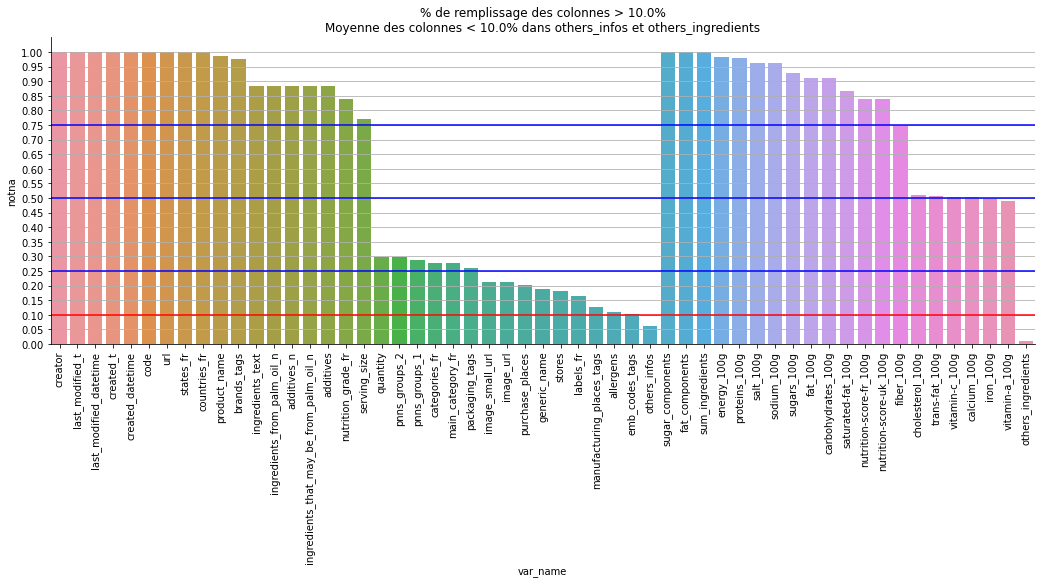

In [89]:
# Amélioration: commenter le code ci-dessous
lim = 0.10
col = info.get_members()

def compute_pareto(df, col, lim, title):
    notna = df[col].notna()    
    pareto = pd.DataFrame(notna.sum(axis = 0) / len(notna))
    pareto = pareto.reset_index()
    pareto.columns = ['var_name', 'notna']
    ind = pareto['notna'] <= lim
    to_drop = pareto.loc[ind, 'var_name']
    mean = pareto.loc[ind, 'notna'].mean()
    pareto = pareto.drop(pareto[ind].index)
    df_tmp = pd.DataFrame([['others_'+title, mean]], columns = pareto.columns)
    pareto = pareto.append(df_tmp, ignore_index=True)
    pareto = pareto.sort_values(by = 'notna', ascending = False)
    return(pareto, to_drop)

col = info.get_members()
pareto, to_drop_infos = compute_pareto(df_missing, col, lim, 'infos')

col = []
for c in cat_main_missing[1:] + cat_others_missing:
    col.extend(c.get_members())

p, to_drop_ingredients = compute_pareto(df_missing, col, lim, 'ingredients')
pareto = pareto.append(p, ignore_index = True, sort = False)

to_drop1 = list(to_drop_infos) + list(to_drop_ingredients)

g = sns.catplot(y = 'notna', x = 'var_name',data = pareto,
                dodge = False, kind = 'bar', height = 5, aspect = 3)

g.set_xticklabels(rotation = 90)
yticks = np.arange(0,1.05,0.05)
g.ax.set_yticks(yticks)
g.ax.yaxis.grid(True)
g.ax.axhline(y = 0.25, color = 'b')
g.ax.axhline(y = 0.5, color = 'b')
g.ax.axhline(y = 0.75, color = 'b')
g.ax.axhline(y = lim, color = 'r')
g.ax.set_title(f'% de remplissage des colonnes > {lim * 100:.1f}%\n\
Moyenne des colonnes < {lim * 100:.1f}% dans others_infos et others_ingredients')

print('Nb de colonnes dans others_infos: ', len(to_drop_infos))
print('Nb de colonnes dans others_ingredients: ', len(to_drop_ingredients))
plt.show()

**Suppression des variables remplies à moins de 10%**

In [90]:
importlib.reload(cl)
df_missing, to_drop = cl.clean_variables(df_missing, how = 'few_notna', var_info = var_info_missing,
                                  drop = True, how_few = 0.10, typ = None, verbose = True)


Shape before drop: (230731, 118)
Shape after drop: (230731, 53)


******************************
'cv_few_notna' report

Those are the specific inputs you have passed to this function, check it:
'drop' = True
'how_few' = 0.1
'typ' = None
'verbose' = True

'cv_few_notna' handles Qualitative AND Numerical variables

# of qualitative variables where the filling rate is <= 10.0% : 6
['origins_tags', 'first_packaging_code_geo', 'cities_tags', 'traces_fr', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_tags']

# of numerical variables where the filling rate is <= 10.0% : 59
['energy-from-fat_100g', 'lauric-acid_100g', 'arachidic-acid_100g', 'behenic-acid_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'alpha-linolenic-acid_100g', 'eicosapentaenoic-acid_100g', 'docosahexaenoic-acid_100g', 'omega-6-fat_100g', 'linoleic-acid_100g', 'gamma-linolenic-acid_100g', 'dihomo-gamma-linolenic-acid_100g', 'omega-9-fat_100g', 'oleic-acid_100g', 

**Maj des catégories de variables**

In [91]:
before = 0
for c in cat_main_missing + cat_others_missing:
    before = before + c.get_members().shape[0]

suppr = 0
for c in cat_main_missing + cat_others_missing:
    suppr = suppr + c.remove_members(to_drop)

print("Nombre de membres avant maj: ", before)
print("Nombre de membres supprimés: ", suppr)
print("Nombre de membres après maj: ", before - suppr)

Nombre de membres avant maj:  118
Nombre de membres supprimés:  65
Nombre de membres après maj:  53


**Visualisation du remplissage des lignes**

In [92]:
def ind_completeness(df, col, title):
    fig, ax = plt.subplots(figsize = (15, 5))
    notna = df[col].notna()
    notna_sum = notna.sum(axis = 1)
    #isna = df[col].isna()
    #isna_sum = isna.sum(axis = 1)

    kwargs = {'cumulative': 1}
    sns.distplot(notna_sum, hist = True, norm_hist = True, hist_kws = kwargs, kde = False, ax = ax)

    ax.set_title(title + " - Nombre d'éléments non vides dans les lignes")
    ax.set_xlabel("Au plus x éléments renseignés dans la ligne")
    ax.set_ylabel("% de lignes")
    xticks = np.arange(min(notna_sum),max(notna_sum),1)
    ax.set_xticks(xticks)
    ax.xaxis.grid(True)
    yticks = np.arange(0,1.05,0.05)
    ax.set_yticks(yticks)
    ax.yaxis.grid(True)
    print(title + ": Nombre de lignes vides: ",(notna_sum==0).sum())
    print(title + ": Nombre de colonnes: ",len(col))
    plt.show()

all: Nombre de lignes vides:  0
all: Nombre de colonnes:  53


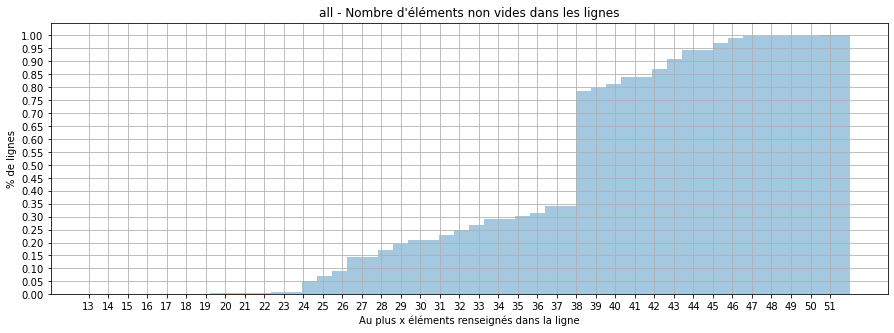

In [93]:
col = []
for c in cat_main_missing + cat_others_missing:
    col.extend(c.get_members())

ind_completeness(df_missing, col, 'all')

**Suppression des lignes dont moins de 23 variables sont remplies**

In [94]:
ind = df_missing[col].notna().sum(axis = 1) <= 23
before = df_missing.shape
print(f"Shape avant maj: ", before)
df_missing = df_missing[~ind]
after = df_missing.shape
print(f"Nombre de lignes supprimées: ", before[0] - after[0])
print(f"Shape après maj: ", after)

Shape avant maj:  (230731, 53)
Nombre de lignes supprimées:  1913
Shape après maj:  (228818, 53)


# Suppression des duplicates

In [95]:
df_dups= df_missing.copy()

In [96]:
var_info_dups = cl.get_var_info(df_dups, how_few = 0.02, what = 'variables')

In [97]:
cat_main_dups, cat_others_dups = copy_cat(cat_main_missing, cat_others_missing)

**Calcul du nombre de dupliqués sur les variables quantitatives**

In [98]:
col = []
for c in cat_main_dups[1:] + cat_others_dups:
    col.extend(c.get_members())
ind_dups = df_dups[col].duplicated()
ind_dups.sum()

52725

Il y a 52725 dupliqués si on ne considère que les variables quantitatives.

**Exploration du pouvoir discriminant des variables qualitatives sur les produits dont les compositions sont identiques**

On va explorer si les variables d'information discriment les individus qui ont des informations numériques dupliquées.

In [99]:
# Amélioration: commenter le code ci-dessous
import copy

log1 = pd.DataFrame(columns = ['var', 'dups'])
for i, var in enumerate(info.get_members()):
    dups = df_dups[var].duplicated().sum()
    log1.loc[i] = [str(var), dups]
log1 = log1.sort_values(by = 'dups', ascending = False)

log3 = pd.DataFrame(columns = ['var', 'dups'])

col = []
for c in cat_main_dups[1:] + cat_others_dups:
    col.extend(c.get_members())
    
for i, var in enumerate(log1['var']):
    c = copy.deepcopy(col)
    c.append(var)
    dups = df_dups[c].duplicated().sum()
    log3.loc[i] = [str(var)+'_'+str(int(log1.loc[log1['var']==var, 'dups'])), dups]

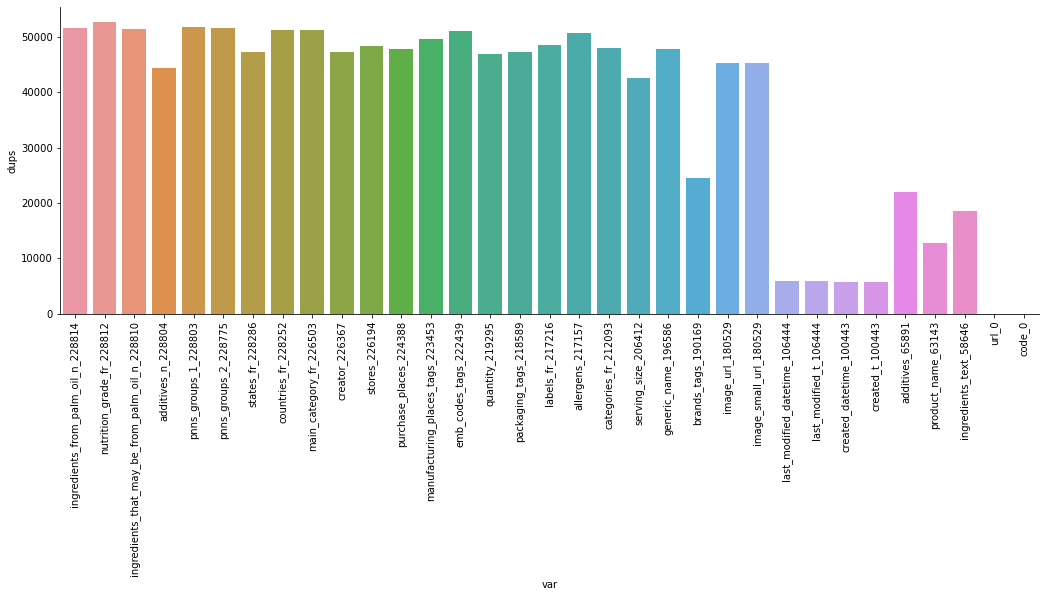

In [100]:
g = sns.catplot(x = 'var', y = 'dups', kind = 'bar', data = log3, height = 5, aspect = 3)
g.set_xticklabels(rotation = 90)

Sans surprise, les informations de création / modification sont très discriminantes. A part cela, les variables 'product_name', 'ingredient_text' et 'brands_tags' discriment le plus les produits ayants des compositions identiques.

**Suppression des lignes identiques de même composition et qui ne sont pas discriminées par la variable 'product_name'**

In [101]:
col = []
for c in cat_main_dups[1:] + cat_others_dups:
    col.extend(c.get_members())
col.append('product_name')
dups = df_dups[col].duplicated()

before = df_dups.shape
print(f"Shape avant maj: ", before)
df_dups = df_dups[~dups]
after = df_dups.shape
print(f"Nombre de lignes supprimées: ", before[0] - after[0])
print(f"Shape après maj: ", after)

Shape avant maj:  (228818, 53)
Nombre de lignes supprimées:  12837
Shape après maj:  (215981, 53)


# Traitement des outliers statistiques

In [102]:
df_out = df_dups.copy()

In [103]:
var_info_out = cl.get_var_info(df_out, how_few = 0.02, what = 'stats')

In [104]:
cat_main_out, cat_others_out = copy_cat(cat_main_dups, cat_others_dups)

**Visualisation de la répartition statistique des variables**

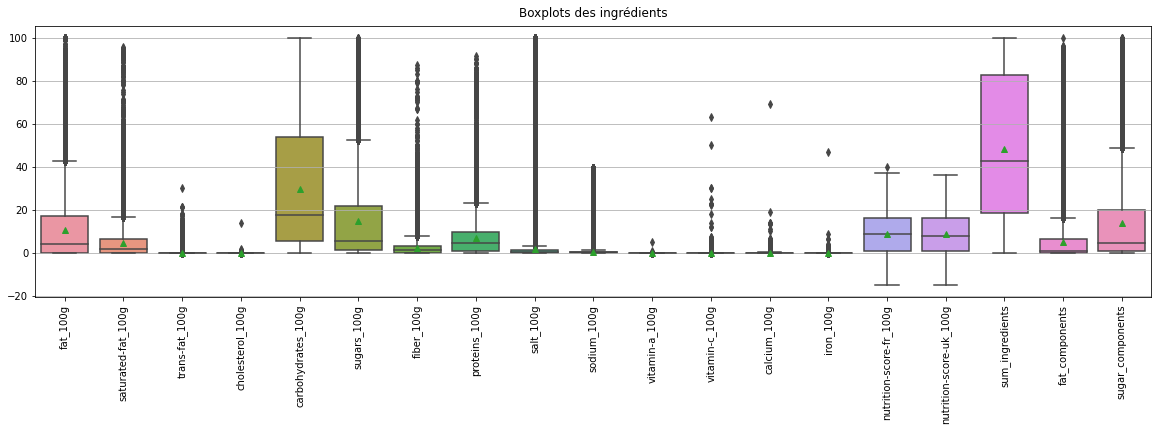

In [105]:
# Plot boxes
col = []
for c in cat_main_out[2:] + cat_others_out:
    col.extend(c.get_members())
d = df_out[col]

fig, ax = plt.subplots(figsize = (20,5))
ax.grid(True)
g = sns.boxplot(data=d, ax = ax,\
            width = 0.8, whis = 1.5, showmeans = True)
g.set_title("Boxplots des ingrédients", y=1.01)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

pass

**Suppression des outliers statistiques pour les produits qui ont la variable pnns_groups_2 renseignée**

Les outliers au sein même d'une catégorie homogène définie par exemple par la variable catégorielle 'pnns_groups_2" peuvent être assimilés à des vrais outliers statistiques. On vérifiera d'ailleurs dans l'exploration de données que les densités de probabilité correspondantes sont plus resserées et donc plus caractéristiques.

On supprime ces outliers.

In [106]:
# Améliorations: commenter le code ci-dessous

col = []
for c in cat_main_out[1:] + cat_others_out:
    col.extend(c.get_members())
# On ne prend pas en compte les variables supplémentaires que j'ai créées
col = col[:-3] 

outliers = {}
to_drop = set()
cut_off_coef = 1.5

# Logs outliers
for var_name in col:
    v = var_info_out.loc[var_info_out['var_name'] == var_name, ['25%', '75%']].to_numpy()
    q25, q75 = v[0]
    iqr = q75 - q25
    cut_off = cut_off_coef * iqr
    lower, upper = q25 - cut_off, q75 + cut_off
    df_ = df_out[df_out['pnns_groups_2'].notna()]
    df_ = df_[~(df_['pnns_groups_2'] == 'unknown')]
    ind = (df_[var_name] < lower) | (df_[var_name] > upper)
    ind = df_[ind].index
    to_drop.update(ind.to_numpy())
    outliers[var_name] = ind

# Counts outliers
nb_outliers = {}
for key in outliers.keys():
    nb_outliers[key] = outliers[key].size

before = df_out.shape
print(f"Shape avant maj: ", before)
df_out = df_out.drop(to_drop, axis = 0)
after = df_out.shape
print(f"Nombre de lignes supprimées: ", before[0] - after[0])
print(f"Shape après maj: ", after)

Shape avant maj:  (215981, 53)
Nombre de lignes supprimées:  14096
Shape après maj:  (201885, 53)


**Comptage des outliers potentiels restants**

On calcule combien on aurait d'outliers statistiques potentiels pour différents seuils de la valeur interquartile.

In [107]:
# Améliorations: commenter le code ci-dessous

col = []
for c in cat_main_out[1:] + cat_others_out:
    col.extend(c.get_members())
# On ne prend pas en compte les variables supplémentaires que j'ai créées
col = col[:-3] 

for cut_off_coef in range(2,15):
    outliers = {}
    to_drop = set()


    # Logs outliers
    for var_name in col:
        v = var_info_out.loc[var_info_out['var_name'] == var_name, ['25%', '75%']].to_numpy()
        q25, q75 = v[0]
        iqr = q75 - q25
        cut_off = cut_off_coef * iqr
        lower, upper = q25 - cut_off, q75 + cut_off

        #ind = (df_out[var_name] < lower) | (df_out[var_name] > upper)
        df_ = df_out
        ind = (df_[var_name] < lower) | (df_[var_name] > upper)
        ind = df_[ind].index
        to_drop.update(ind.to_numpy())
        outliers[var_name] = ind

    print(f"Outliers potentiels au-delà de {cut_off_coef} la distance interquartile: {len(to_drop)}")

Outliers potentiels au-delà de 2 la distance interquartile: 52842
Outliers potentiels au-delà de 3 la distance interquartile: 35603
Outliers potentiels au-delà de 4 la distance interquartile: 27966
Outliers potentiels au-delà de 5 la distance interquartile: 22337
Outliers potentiels au-delà de 6 la distance interquartile: 20110
Outliers potentiels au-delà de 7 la distance interquartile: 14690
Outliers potentiels au-delà de 8 la distance interquartile: 12904
Outliers potentiels au-delà de 9 la distance interquartile: 11970
Outliers potentiels au-delà de 10 la distance interquartile: 10943
Outliers potentiels au-delà de 11 la distance interquartile: 9879
Outliers potentiels au-delà de 12 la distance interquartile: 8949
Outliers potentiels au-delà de 13 la distance interquartile: 8429
Outliers potentiels au-delà de 14 la distance interquartile: 7871


**Suppression des outliers statistiques restants au-delà de 5 fois la distance interquartile**

In [108]:
# Améliorations: commenter le code ci-dessous

col = []
for c in cat_main_out[1:] + cat_others_out:
    col.extend(c.get_members())
# On ne prend pas en compte les variables supplémentaires que j'ai créées
col = col[:-3] 

outliers = {}
to_drop = set()
cut_off_coef = 5

# Logs outliers
for var_name in col:
    v = var_info_out.loc[var_info_out['var_name'] == var_name, ['25%', '75%']].to_numpy()
    q25, q75 = v[0]
    iqr = q75 - q25
    cut_off = cut_off_coef * iqr
    lower, upper = q25 - cut_off, q75 + cut_off
    
    #ind = (df_out[var_name] < lower) | (df_out[var_name] > upper)
    df_ = df_out
    ind = (df_[var_name] < lower) | (df_[var_name] > upper)
    ind = df_[ind].index
    to_drop.update(ind.to_numpy())
    outliers[var_name] = ind

# Counts outliers
nb_outliers = {}
for key in outliers.keys():
    nb_outliers[key] = outliers[key].size

before = df_out.shape
print(f"Shape avant maj: ", before)
df_out = df_out.drop(to_drop, axis = 0)
after = df_out.shape
print(f"Nombre de lignes supprimées: ", before[0] - after[0])
print(f"Shape après maj: ", after)

Shape avant maj:  (201885, 53)
Nombre de lignes supprimées:  22337
Shape après maj:  (179548, 53)


A ce stade, on ne prend pas d'actions sur les autres outliers.

En effet, les outliers peuvent être dus à des disparités dans les effectifs des différentes catégories d'aliments. Par exemple, on a peut-être quelques produits très sucrés, gras ou proteinés qui s'écartent de la moyenne. On veut justement pouvoir les identifier.

**Comptage des outliers potentiels restants > 1.5 fois la distance interquartile**

In [109]:
# Améliorations: commenter le code ci-dessous

col = []
for c in cat_main_out[1:] + cat_others_out:
    col.extend(c.get_members())
# On ne prend pas en compte les variables supplémentaires que j'ai créées
col = col[:-3] 

outliers = {}
cut_off_coef = 1.5

# Logs outliers
for var_name in col:
    v = var_info_out.loc[var_info_out['var_name'] == var_name, ['25%', '75%']].to_numpy()
    q25, q75 = v[0]
    iqr = q75 - q25
    cut_off = cut_off_coef * iqr
    lower, upper = q25 - cut_off, q75 + cut_off
    ind = (df_out[var_name] < lower) | (df_out[var_name] > upper)
    ind = df_out[ind].index
    outliers[var_name] = ind

# Counts outliers
nb_outliers = {}
for key in outliers.keys():
    nb_outliers[key] = outliers[key].size
    
nb_outliers

{'energy_100g': 322,
 'fat_100g': 4024,
 'saturated-fat_100g': 5983,
 'trans-fat_100g': 0,
 'cholesterol_100g': 5365,
 'carbohydrates_100g': 0,
 'sugars_100g': 11213,
 'fiber_100g': 4424,
 'proteins_100g': 4138,
 'salt_100g': 6692,
 'sodium_100g': 6691,
 'vitamin-a_100g': 3789,
 'vitamin-c_100g': 7770,
 'calcium_100g': 3125,
 'iron_100g': 2616,
 'nutrition-score-fr_100g': 0,
 'nutrition-score-uk_100g': 0}

# Imputation des valeurs manquantes

In [110]:
df_imp = df_out.copy()

In [111]:
var_info_imp = cl.get_var_info(df_imp, how_few = 0.02)

In [112]:
cat_main_imp, cat_others_imp = copy_cat(cat_main_out, cat_others_out)

**Imputation des valeurs manquantes qualitatives par le mot clé 'missing'**

In [113]:
df_imp, log = cl.clean_variables(df_imp, how = 'missing', var_info = var_info_imp,
                         variables = info.get_members(), correct = True, correction = 'missing')

Index(['var_rank', 'var_name', 'uniques', 'uniques_rate', 'size', 'count',
       'nans', 'nan_rate', 'check', 'dtype', 'type', 'type_guess', 'mean',
       'median', 'std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurtosis'],
      dtype='object')


******************************
'cv_missing' report

Those are the specific inputs you have passed to this function, check it:
'variables' = 0                                        code
1                                         url
2                                     creator
3                                   created_t
4                            created_datetime
5                             last_modified_t
6                      last_modified_datetime
7                                product_name
8                                generic_name
9                                    quantity
11                             packaging_tags
13                                brands_tags
16                              categories_fr
20      

**Imputation des valeurs manquantes quantitatives par la médiane**  
On constate lors de l'exploration des données que les variables sont souvent multi-modales ou asymétriques. On décide donc d'imputer les valeurs manquantes par la médiane. 

In [114]:
col = []
for c in cat_main_imp[1:] + cat_others_imp:
    col.extend(c.get_members())
for var in col:
    df_imp.loc[df_imp[var].isna(), var] = df_imp[var].median()

**Vérification visuelle**

Nb de colonnes dans others_infos:  0
Nb de colonnes dans others_ingredients:  0


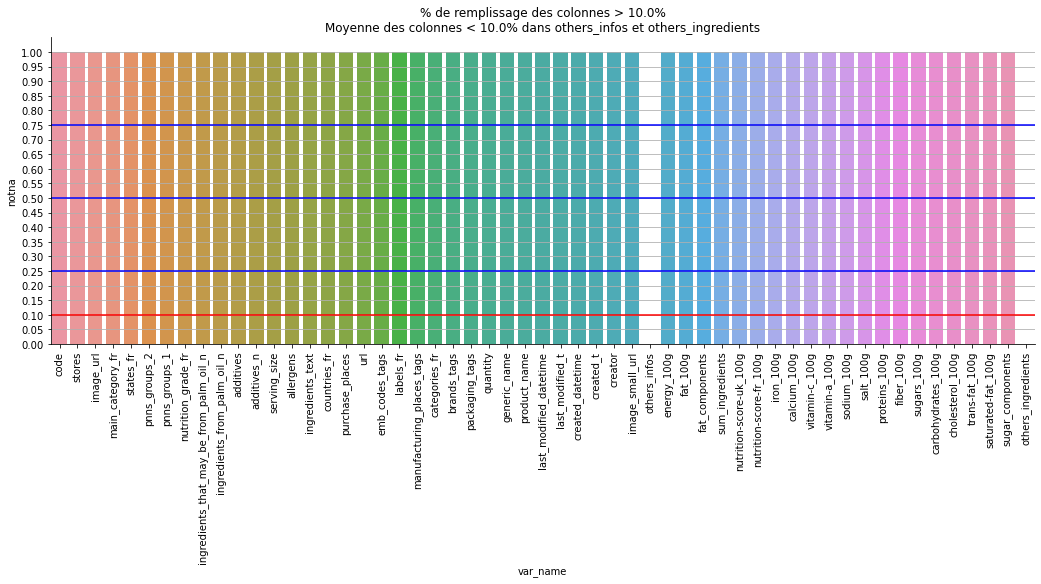

In [115]:
lim = 0.10
col = info.get_members()

def compute_pareto(df, col, lim, title):
    notna = df[col].notna()    
    pareto = pd.DataFrame(notna.sum(axis = 0) / len(notna))
    pareto = pareto.reset_index()
    pareto.columns = ['var_name', 'notna']
    ind = pareto['notna'] <= lim
    to_drop = pareto.loc[ind, 'var_name']
    mean = pareto.loc[ind, 'notna'].mean()
    pareto = pareto.drop(pareto[ind].index)
    df_tmp = pd.DataFrame([['others_'+title, mean]], columns = pareto.columns)
    pareto = pareto.append(df_tmp, ignore_index=True)
    pareto = pareto.sort_values(by = 'notna', ascending = False)
    return(pareto, to_drop)

col = info.get_members()
pareto, to_drop_infos = compute_pareto(df_imp, col, lim, 'infos')

col = []
for c in cat_main_imp[1:] + cat_others_imp:
    col.extend(c.get_members())

p, to_drop_ingredients = compute_pareto(df_imp, col, lim, 'ingredients')
pareto = pareto.append(p, ignore_index = True, sort = False)

to_drop1 = list(to_drop_infos) + list(to_drop_ingredients)

g = sns.catplot(y = 'notna', x = 'var_name',data = pareto,
                dodge = False, kind = 'bar', height = 5, aspect = 3)

g.set_xticklabels(rotation = 90)
yticks = np.arange(0,1.05,0.05)
g.ax.set_yticks(yticks)
g.ax.yaxis.grid(True)
g.ax.axhline(y = 0.25, color = 'b')
g.ax.axhline(y = 0.5, color = 'b')
g.ax.axhline(y = 0.75, color = 'b')
g.ax.axhline(y = lim, color = 'r')
g.ax.set_title(f'% de remplissage des colonnes > {lim * 100:.1f}%\n\
Moyenne des colonnes < {lim * 100:.1f}% dans others_infos et others_ingredients')

print('Nb de colonnes dans others_infos: ', len(to_drop_infos))
print('Nb de colonnes dans others_ingredients: ', len(to_drop_ingredients))
plt.show()

# Sauvegarde du jeu de données nettoyé

In [116]:
df_imp.to_csv("df_cleaned.csv")